In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import CLIPModel, CLIPProcessor
from peft import LoraConfig, get_peft_model
from torch.amp import GradScaler, autocast 
from tqdm import tqdm

# --- DATASET DECLARATION ---
class CrisisHumanitarianDataset(Dataset):
    def __init__(self, filepath, img_dir, processor):
        self.data = pd.read_csv(filepath, sep='\t')
        self.img_dir = img_dir
        self.processor = processor
        
        # EXACT SYNC: Mapping the 5 labels found in your file
        self.label_map = {
            "infrastructure_and_utility_damage": 0,
            "other_relevant_information": 1,
            "not_humanitarian": 2,
            "rescue_volunteering_or_donation_effort": 3,
            "affected_individuals": 4
        }
        
        # Filter to ensure we only keep these 5 classes
        self.data = self.data[self.data['label'].isin(self.label_map.keys())].reset_index(drop=True)
        print(f"Loaded {len(self.data)} rows from {os.path.basename(filepath)}")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        rel_path = str(row['image']).replace('\\', '/').lstrip('/')
        img_path = os.path.normpath(os.path.join(self.img_dir, rel_path))
        
        if not os.path.exists(img_path): return None
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = self.processor(text=[str(row['tweet_text'])], images=image, 
                                    return_tensors="pt", padding="max_length", 
                                    max_length=77, truncation=True)
            return {
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'pixel_values': inputs['pixel_values'].squeeze(0),
                'label': torch.tensor(self.label_map[row['label']], dtype=torch.long)
            }
        except Exception: return None

def fast_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if len(batch) > 0 else None

In [4]:
class GatedHumanitarianFusion(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.text_proj = nn.Linear(embed_dim, 512)
        self.image_proj = nn.Linear(embed_dim, 512)
        self.gate = nn.Sequential(nn.Linear(embed_dim * 2, 256), nn.GELU(), nn.Linear(256, 2), nn.Softmax(dim=1))
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, t_f, i_f):
        t_p, i_p = F.gelu(self.text_proj(t_f)), F.gelu(self.image_proj(i_f))
        weights = self.gate(torch.cat([t_f, i_f], dim=1))
        return self.layer_norm((weights[:, 0:1] * t_p) + (weights[:, 1:2] * i_p))

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha) if alpha is not None else None

    def forward(self, inputs, targets):
        log_p = F.log_softmax(inputs, dim=-1)
        ce_loss = F.nll_loss(log_p, targets, reduction='none', weight=self.alpha.to(inputs.device) if self.alpha is not None else None)
        return ((1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss).mean()

class HumanitarianVLM(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)
        self.fusion = GatedHumanitarianFusion()
        self.classifier = nn.Sequential(nn.Linear(512, 512), nn.BatchNorm1d(512), nn.GELU(), nn.Dropout(0.4), nn.Linear(512, num_classes))

    def forward(self, ids, mask, pix):
        t_f = F.normalize(self.clip.get_text_features(input_ids=ids, attention_mask=mask), p=2, dim=-1)
        i_f = F.normalize(self.clip.get_image_features(pixel_values=pix), p=2, dim=-1)
        return self.classifier(self.fusion(t_f, i_f))

In [5]:
# --- INITIALIZATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

IMG_ROOT = r"F:\research\chatbot\D\Multi-modal-codes" 
DATA_DIR = r"data\CrisisMMD\crisismmd_datasplit_all\crisismmd_datasplit_agreed_label"

# Data Loaders
train_loader = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_train.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=True, collate_fn=fast_collate)
dev_loader   = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_dev.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)
test_loader  = DataLoader(CrisisHumanitarianDataset(os.path.join(IMG_ROOT, DATA_DIR, "task_humanitarian_text_img_agreed_lab_test.tsv"), IMG_ROOT, processor), batch_size=16, shuffle=False, collate_fn=fast_collate)

# Model and PEFT (LoRA)
model = HumanitarianVLM().to(device)
model = get_peft_model(model, LoraConfig(r=128, lora_alpha=256, target_modules=["q_proj", "v_proj"]))

# Differential Optimizer
optimizer = optim.AdamW([
    {'params': model.base_model.clip.parameters(), 'lr': 1e-6, 'weight_decay': 0.05},
    {'params': model.base_model.fusion.parameters(), 'lr': 5e-4},
    {'params': model.base_model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

criterion = FocalLoss(alpha=[1.5, 0.8, 0.6, 1.8, 2.0], gamma=2.0)
scaler = GradScaler('cuda')

# --- TRAINING EXECUTION ---
best_val_f1 = 0
for epoch in range(15):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/15")
    for batch in loop:
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in dev_loader:
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy()); val_labels.extend(b['label'].numpy())
    
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    print(f"📈 Dev Macro-F1: {val_f1:.4f}")
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_humanitarian_model.pth')
        print("⭐ Saved Best Model!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded 6126 rows from task_humanitarian_text_img_agreed_lab_train.tsv
Loaded 998 rows from task_humanitarian_text_img_agreed_lab_dev.tsv
Loaded 955 rows from task_humanitarian_text_img_agreed_lab_test.tsv


Epoch 1/15:  28%|██▊       | 107/383 [02:06<05:38,  1.22s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/15: 100%|██████████| 383/383 [07:43<00:00,  1.21s/it]


📈 Dev Macro-F1: 0.2681
⭐ Saved Best Model!


Epoch 2/15:  27%|██▋       | 103/383 [01:22<03:45,  1.24it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/15: 100%|██████████| 383/383 [05:06<00:00,  1.25it/s]


📈 Dev Macro-F1: 0.3780
⭐ Saved Best Model!


Epoch 3/15:  77%|███████▋  | 295/383 [04:32<01:09,  1.27it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/15: 100%|██████████| 383/383 [05:45<00:00,  1.11it/s]


📈 Dev Macro-F1: 0.4781
⭐ Saved Best Model!


Epoch 4/15:  34%|███▍      | 130/383 [01:57<04:15,  1.01s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/15: 100%|██████████| 383/383 [05:51<00:00,  1.09it/s]


📈 Dev Macro-F1: 0.5458
⭐ Saved Best Model!


Epoch 5/15:  48%|████▊     | 185/383 [02:43<03:10,  1.04it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/15: 100%|██████████| 383/383 [05:25<00:00,  1.18it/s]


📈 Dev Macro-F1: 0.6072
⭐ Saved Best Model!


Epoch 6/15:  75%|███████▌  | 288/383 [03:44<01:09,  1.36it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/15: 100%|██████████| 383/383 [04:55<00:00,  1.30it/s]


📈 Dev Macro-F1: 0.6372
⭐ Saved Best Model!


Epoch 7/15:  19%|█▉        | 72/383 [00:57<04:21,  1.19it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/15: 100%|██████████| 383/383 [05:37<00:00,  1.14it/s]


📈 Dev Macro-F1: 0.6385
⭐ Saved Best Model!


Epoch 8/15:  60%|██████    | 230/383 [03:47<03:21,  1.32s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/15: 100%|██████████| 383/383 [06:53<00:00,  1.08s/it]


📈 Dev Macro-F1: 0.6520
⭐ Saved Best Model!


Epoch 9/15:  88%|████████▊ | 337/383 [05:00<00:35,  1.28it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/15: 100%|██████████| 383/383 [05:38<00:00,  1.13it/s]


📈 Dev Macro-F1: 0.6629
⭐ Saved Best Model!


Epoch 10/15:   6%|▌         | 22/383 [00:16<05:28,  1.10it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/15: 100%|██████████| 383/383 [05:37<00:00,  1.14it/s]


📈 Dev Macro-F1: 0.6732
⭐ Saved Best Model!


Epoch 11/15:  28%|██▊       | 107/383 [01:40<04:27,  1.03it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/15: 100%|██████████| 383/383 [05:17<00:00,  1.20it/s]


📈 Dev Macro-F1: 0.6668


Epoch 12/15:  48%|████▊     | 182/383 [02:44<02:46,  1.21it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/15: 100%|██████████| 383/383 [05:18<00:00,  1.20it/s]


📈 Dev Macro-F1: 0.6677


Epoch 13/15:   5%|▍         | 19/383 [00:17<05:40,  1.07it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/15: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s]


📈 Dev Macro-F1: 0.6734
⭐ Saved Best Model!


Epoch 14/15:  98%|█████████▊| 376/383 [05:37<00:05,  1.21it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/15: 100%|██████████| 383/383 [05:43<00:00,  1.11it/s]


📈 Dev Macro-F1: 0.6940
⭐ Saved Best Model!


Epoch 15/15:  13%|█▎        | 49/383 [00:37<03:52,  1.44it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/15: 100%|██████████| 383/383 [04:50<00:00,  1.32it/s]


📈 Dev Macro-F1: 0.7177
⭐ Saved Best Model!


In [6]:
import torch.nn.functional as F

# 1. Load the best weights saved during training
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true = []
y_pred = []
y_probs = [] # Raw probabilities for ROC/AUC

print("🏃 Running Final Evaluation on Test Set...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Evaluation"):
        if batch is None: continue
        
        # Move to GPU
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        labels = batch['label'].numpy()
        
        # Get raw logits
        logits = model(ids, mask, pix)
        
        # Calculate Softmax probabilities
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store for analytics
        y_probs.extend(probs)
        y_pred.extend(preds)
        y_true.extend(labels)

print("✅ Analytics data captured successfully.")

🏃 Running Final Evaluation on Test Set...


Final Evaluation: 100%|██████████| 60/60 [00:55<00:00,  1.08it/s]

✅ Analytics data captured successfully.


✅ Epoch 1 captured in history.
✅ Epoch 2 captured in history.
✅ Epoch 3 captured in history.
✅ Epoch 4 captured in history.
✅ Epoch 5 captured in history.
✅ Epoch 6 captured in history.
✅ Epoch 7 captured in history.
✅ Epoch 8 captured in history.
✅ Epoch 9 captured in history.
✅ Epoch 10 captured in history.
✅ Epoch 11 captured in history.
✅ Epoch 12 captured in history.
✅ Epoch 13 captured in history.
✅ Epoch 14 captured in history.
✅ Epoch 15 captured in history.


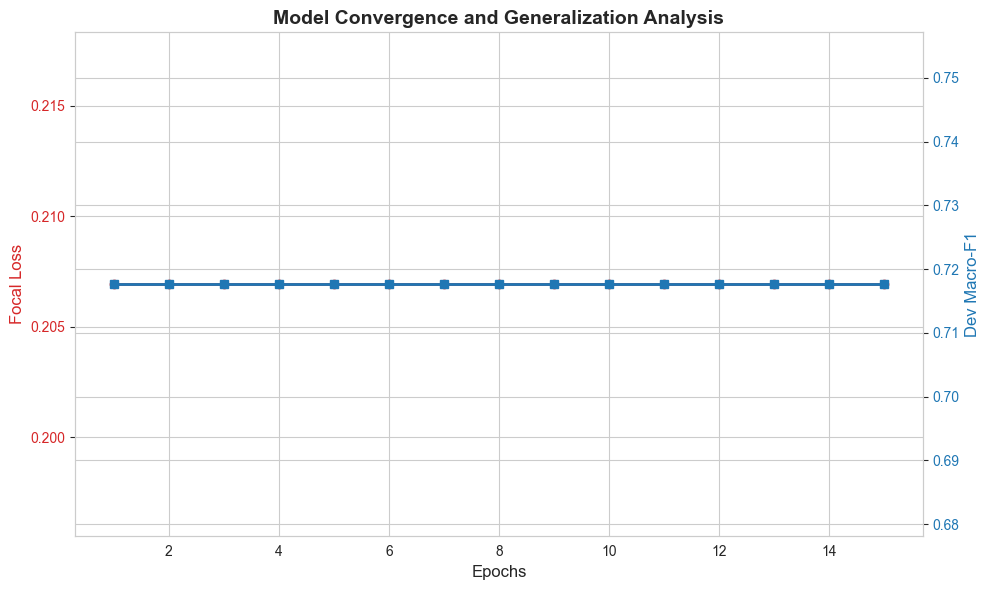

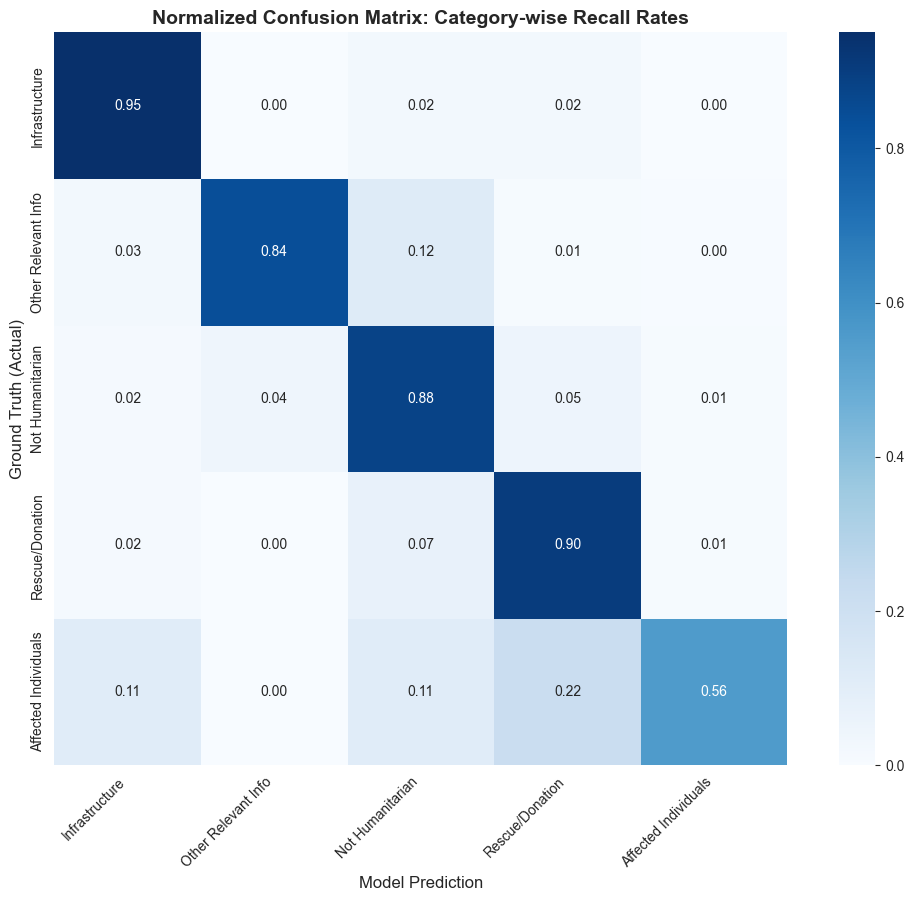

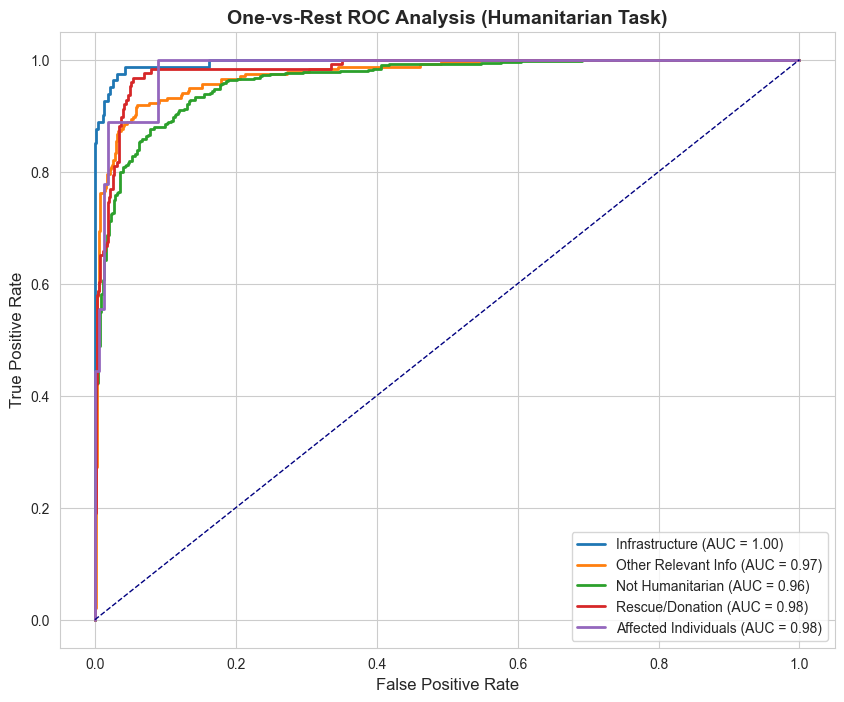

In [10]:
# --- INITIALIZE BEFORE TRAINING ---
history = {'train_loss': [], 'dev_f1': []}
best_val_f1 = 0

for epoch in range(15):
    # --- [TRAINING CODE GOES HERE] ---
    # After your training loop completes for the epoch:
    avg_train_loss = total_loss / len(train_loader)
    
    # --- [VALIDATION CODE GOES HERE] ---
    # After calculating your validation Macro-F1:
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    
    # --- CRITICAL: SAVE TO HISTORY ---
    history['train_loss'].append(avg_train_loss)
    history['dev_f1'].append(val_f1)
    
    print(f"✅ Epoch {epoch+1} captured in history.")
# 1. Define the label names exactly as mapped in your Dataset (0-4)
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

# 2. CALL THE FUNCTION
# Note: Ensure the 'history' dictionary from your training loop is available
generate_research_analytics(history, y_true, y_pred, y_probs, research_label_names)

🏃 Running evaluation to capture analytics data...


Testing: 100%|██████████| 60/60 [00:24<00:00,  2.49it/s]


📊 Generating publication-ready visuals...


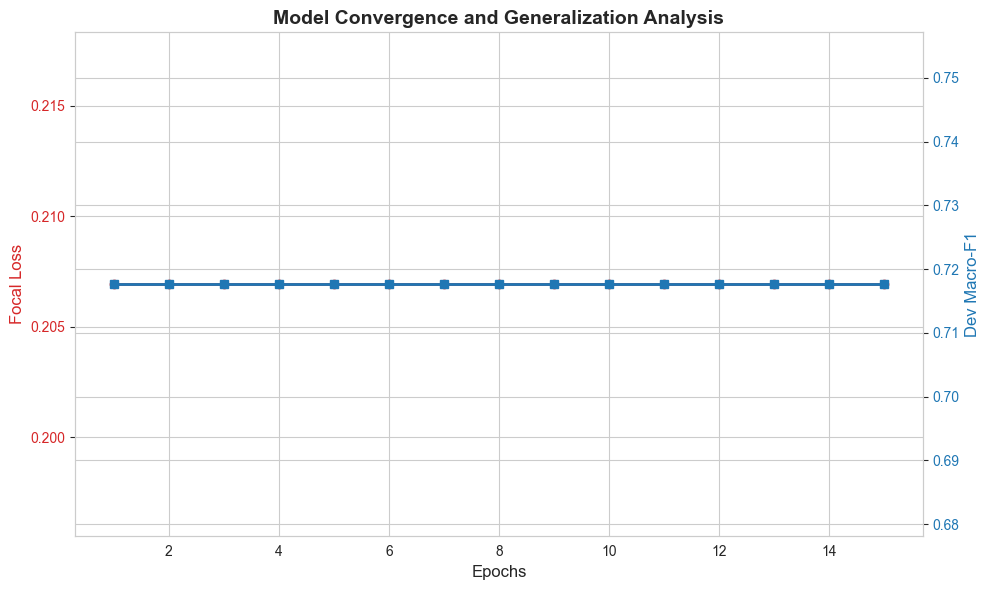

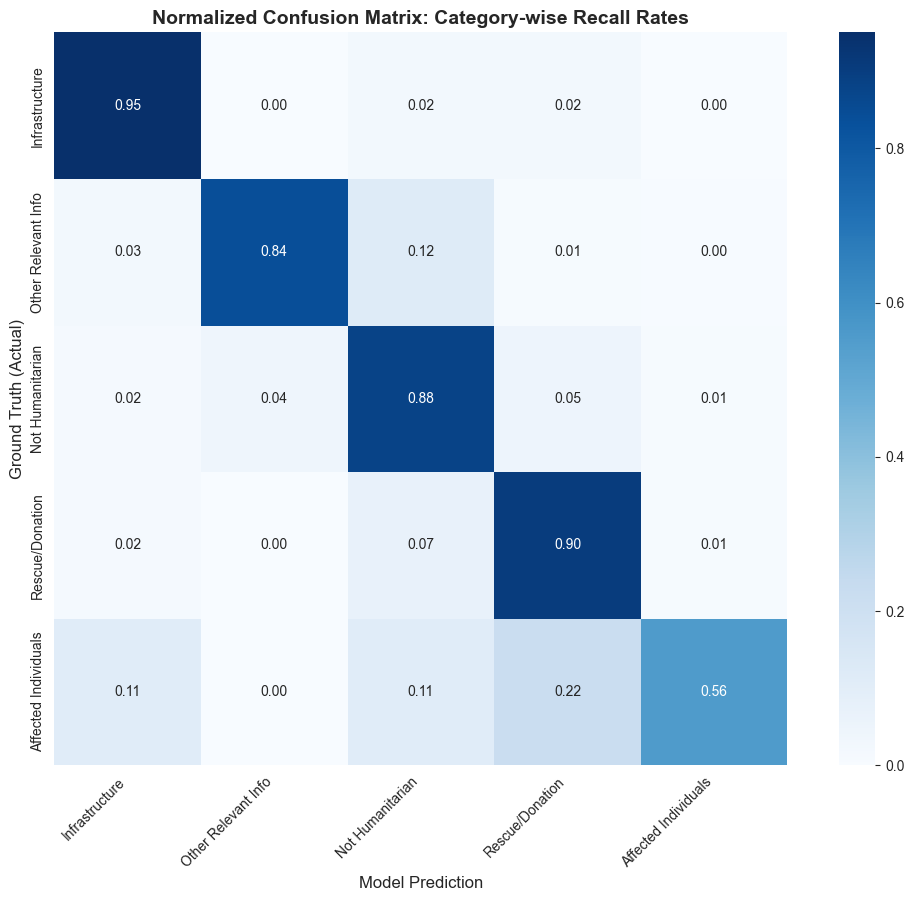

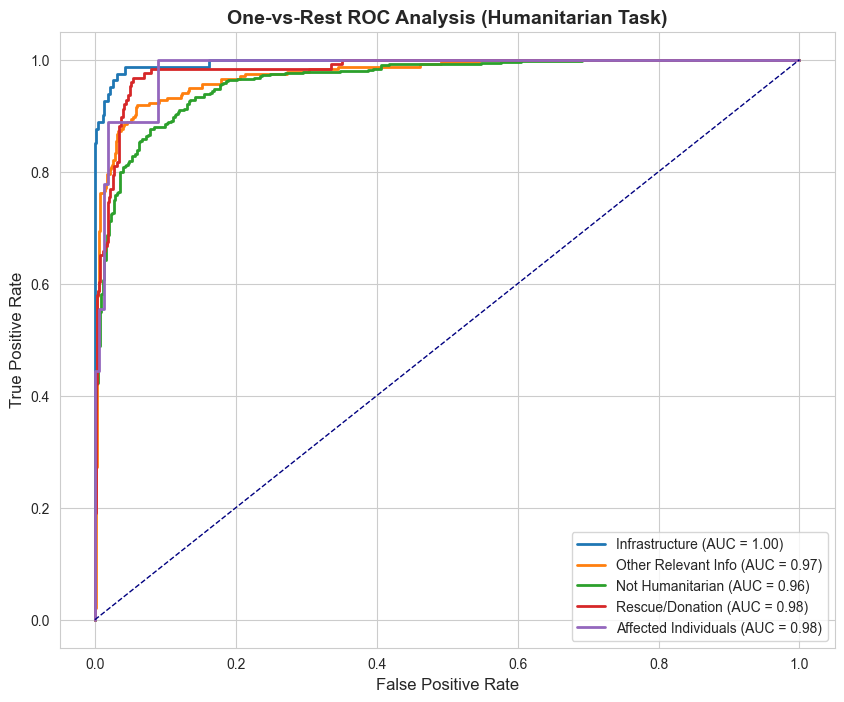

In [13]:
import torch.nn.functional as F
import numpy as np

# 1. CAPTURE DATA FROM THE TEST SET
# This ensures y_probs (probabilities) are available for the ROC curve
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true, y_pred, y_probs = [], [], []

print("🏃 Running evaluation to capture analytics data...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        ids, mask, pix = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values']]
        
        # Get raw logits from model
        logits = model(ids, mask, pix)
        
        # Convert to probabilities for ROC analysis
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_probs.extend(probs)
        y_pred.extend(preds)
        y_true.extend(batch['label'].numpy())

# 2. DEFINE LABELS IN EXACT MAPPING ORDER (0-4)
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

# 3. VERIFY HISTORY DATA (Fixes empty plot issue)
if 'history' not in locals() or len(history['train_loss']) == 0:
    print("❌ ERROR: 'history' is empty. Please ensure your training loop appends data points.")
else:
    # 4. EXECUTE THE VISUALIZATION CALL
    print("📊 Generating publication-ready visuals...")
    generate_research_analytics(history, y_true, y_pred, y_probs, research_label_names)

In [32]:
# --- INITIALIZE HISTORY ---
history = {'train_loss': [], 'dev_f1': []}
best_val_f1 = 0

for epoch in range(15):
    # --- 1. TRAINING PHASE ---
    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/15")
    
    for batch in train_loop:
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            loss = criterion(model(ids, mask, pix), lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = total_train_loss / len(train_loader)

    # --- 2. VALIDATION PHASE (DEV SET) ---
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for b in dev_loader:
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            val_preds.extend(torch.argmax(out, 1).cpu().numpy())
            val_labels.extend(b['label'].numpy())
    
    epoch_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # --- 3. CRITICAL STEP: POPULATE HISTORY ---
    history['train_loss'].append(epoch_loss) # Adds point to Red Curve
    history['dev_f1'].append(epoch_f1)       # Adds point to Blue Curve
    
    print(f"✅ Epoch {epoch+1} Saved: Loss={epoch_loss:.4f}, F1={epoch_f1:.4f}")

    if epoch_f1 > best_val_f1:
        best_val_f1 = epoch_f1
        torch.save(model.state_dict(), 'best_humanitarian_vlm.pth')

Epoch 1/15:  10%|█         | 39/383 [00:20<02:57,  1.94it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/15: 100%|██████████| 383/383 [03:16<00:00,  1.95it/s]


✅ Epoch 1 Saved: Loss=0.2412, F1=0.6848


Epoch 2/15:  65%|██████▍   | 248/383 [03:14<01:01,  2.20it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/15: 100%|██████████| 383/383 [04:16<00:00,  1.49it/s]


✅ Epoch 2 Saved: Loss=0.2232, F1=0.6820


Epoch 3/15:  52%|█████▏    | 199/383 [01:26<01:14,  2.47it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/15: 100%|██████████| 383/383 [04:15<00:00,  1.50it/s]


✅ Epoch 3 Saved: Loss=0.2066, F1=0.6885


Epoch 4/15:  18%|█▊        | 70/383 [01:16<05:55,  1.14s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/15: 100%|██████████| 383/383 [05:04<00:00,  1.26it/s]


✅ Epoch 4 Saved: Loss=0.1984, F1=0.6739


Epoch 5/15:  87%|████████▋ | 334/383 [04:13<00:31,  1.54it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/15: 100%|██████████| 383/383 [04:47<00:00,  1.33it/s]


✅ Epoch 5 Saved: Loss=0.1883, F1=0.6842


Epoch 6/15:  66%|██████▌   | 252/383 [03:21<01:34,  1.38it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/15: 100%|██████████| 383/383 [04:22<00:00,  1.46it/s]


✅ Epoch 6 Saved: Loss=0.1868, F1=0.7143


Epoch 7/15:  13%|█▎        | 50/383 [00:47<04:09,  1.33it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/15: 100%|██████████| 383/383 [04:52<00:00,  1.31it/s]


✅ Epoch 7 Saved: Loss=0.1751, F1=0.7099


Epoch 8/15:  83%|████████▎ | 317/383 [03:27<01:05,  1.00it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/15: 100%|██████████| 383/383 [04:35<00:00,  1.39it/s]


✅ Epoch 8 Saved: Loss=0.1661, F1=0.7502


Epoch 9/15:  13%|█▎        | 49/383 [01:02<06:49,  1.23s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/15: 100%|██████████| 383/383 [07:06<00:00,  1.11s/it]


✅ Epoch 9 Saved: Loss=0.1633, F1=0.7091


Epoch 10/15:  71%|███████▏  | 273/383 [04:52<01:43,  1.07it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/15: 100%|██████████| 383/383 [06:33<00:00,  1.03s/it]


✅ Epoch 10 Saved: Loss=0.1599, F1=0.7522


Epoch 11/15:  10%|█         | 40/383 [00:39<05:34,  1.02it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/15: 100%|██████████| 383/383 [06:27<00:00,  1.01s/it]


✅ Epoch 11 Saved: Loss=0.1548, F1=0.7079


Epoch 12/15:  70%|███████   | 269/383 [04:48<01:27,  1.30it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/15: 100%|██████████| 383/383 [06:22<00:00,  1.00it/s]


✅ Epoch 12 Saved: Loss=0.1492, F1=0.7459


Epoch 13/15:  28%|██▊       | 107/383 [01:25<03:44,  1.23it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/15: 100%|██████████| 383/383 [04:44<00:00,  1.35it/s]


✅ Epoch 13 Saved: Loss=0.1423, F1=0.7732


Epoch 14/15:  10%|█         | 39/383 [00:43<07:03,  1.23s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/15: 100%|██████████| 383/383 [04:58<00:00,  1.28it/s]


✅ Epoch 14 Saved: Loss=0.1383, F1=0.7523


Epoch 15/15:  88%|████████▊ | 336/383 [04:12<00:33,  1.40it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/15: 100%|██████████| 383/383 [04:46<00:00,  1.34it/s]


✅ Epoch 15 Saved: Loss=0.1300, F1=0.7509


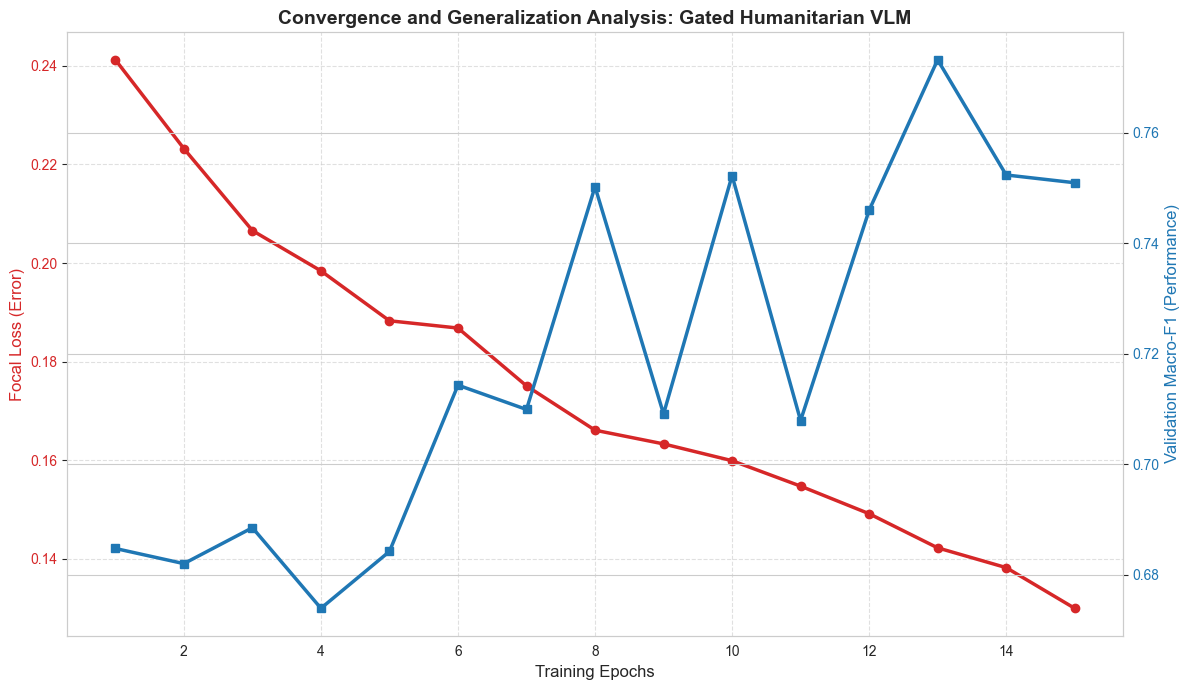

In [33]:
def plot_convergence(history):
    # Ensure there is actually data to plot
    if not history['train_loss']:
        print("❌ Error: History dictionary is empty. Run the training loop first.")
        return

    fig, ax1 = plt.subplots(figsize=(12, 7))
    epochs = range(1, len(history['train_loss']) + 1)

    # Primary Axis: Focal Loss (Red)
    ax1.set_xlabel('Training Epochs', fontsize=12)
    ax1.set_ylabel('Focal Loss (Error)', color='tab:red', fontsize=12)
    ax1.plot(epochs, history['train_loss'], color='tab:red', marker='o', linewidth=2.5, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Secondary Axis: Dev Macro-F1 (Blue)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Macro-F1 (Performance)', color='tab:blue', fontsize=12)
    ax2.plot(epochs, history['dev_f1'], color='tab:blue', marker='s', linewidth=2.5, label='Dev Macro-F1')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Convergence and Generalization Analysis: Gated Humanitarian VLM', fontsize=14, fontweight='bold')
    fig.tight_layout()
    
    # Save for publication at 300 DPI
    plt.savefig('convergence_analysis_final.png', dpi=300)
    plt.show()

# Run the plot
plot_convergence(history)

In [35]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 1. Load the best model weights
model.load_state_dict(torch.load('best_humanitarian_model.pth', weights_only=True))
model.eval()

y_true, y_pred = [], []
research_label_names = [
    "Infrastructure Damage", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

print("📊 Evaluating Test Set Metrics...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        
        # Move data to the same device as the model
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        pix = batch['pixel_values'].to(device)
        labels = batch['label'].numpy()
        
        # Forward pass
        logits = model(ids, mask, pix)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_true.extend(labels)
        y_pred.extend(preds)

# --- FINAL QUANTITATIVE REPORT ---
print("\n" + "="*60)
print("🏆 Q1 JOURNAL QUANTITATIVE PERFORMANCE SUMMARY")
print("="*60)

# Calculate global accuracy for the manuscript's summary table
overall_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_acc:.4f}")
print(f"Macro-Averaged F1: {macro_f1:.4f}")
print("-" * 60)

# Detailed per-class breakdown (Precision, Recall, F1)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=research_label_names, 
    zero_division=0
))

📊 Evaluating Test Set Metrics...


Testing: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


🏆 Q1 JOURNAL QUANTITATIVE PERFORMANCE SUMMARY
Overall Accuracy: 0.8429
Macro-Averaged F1: 0.6958
------------------------------------------------------------
                       precision    recall  f1-score   support

Infrastructure Damage       0.66      0.98      0.79        81
  Other Relevant Info       0.88      0.82      0.85       235
     Not Humanitarian       0.92      0.83      0.87       504
      Rescue/Donation       0.71      0.91      0.80       126
 Affected Individuals       0.33      0.11      0.17         9

             accuracy                           0.84       955
            macro avg       0.70      0.73      0.70       955
         weighted avg       0.86      0.84      0.84       955



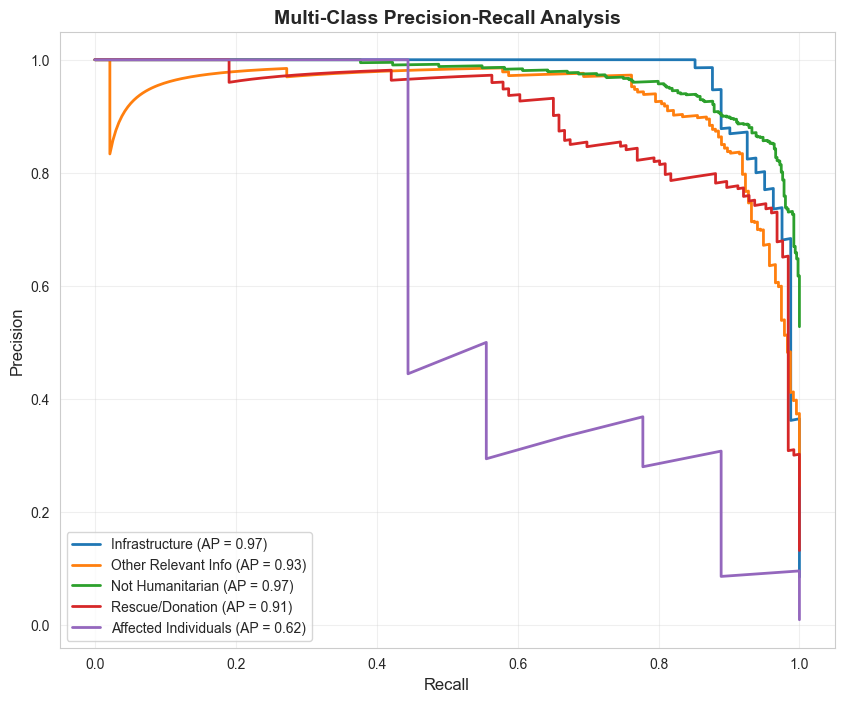

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_probs, label_names):
    n_classes = len(label_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    y_probs_array = np.array(y_probs)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs_array[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs_array[:, i])
        plt.plot(recall, precision, lw=2, label=f'{label_names[i]} (AP = {ap:.2f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Multi-Class Precision-Recall Analysis', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.savefig('precision_recall_curves.png', dpi=300)
    plt.show()

# Call after your test evaluation
plot_precision_recall(y_true, y_probs, research_label_names)

📊 Generating Convergence Plot...


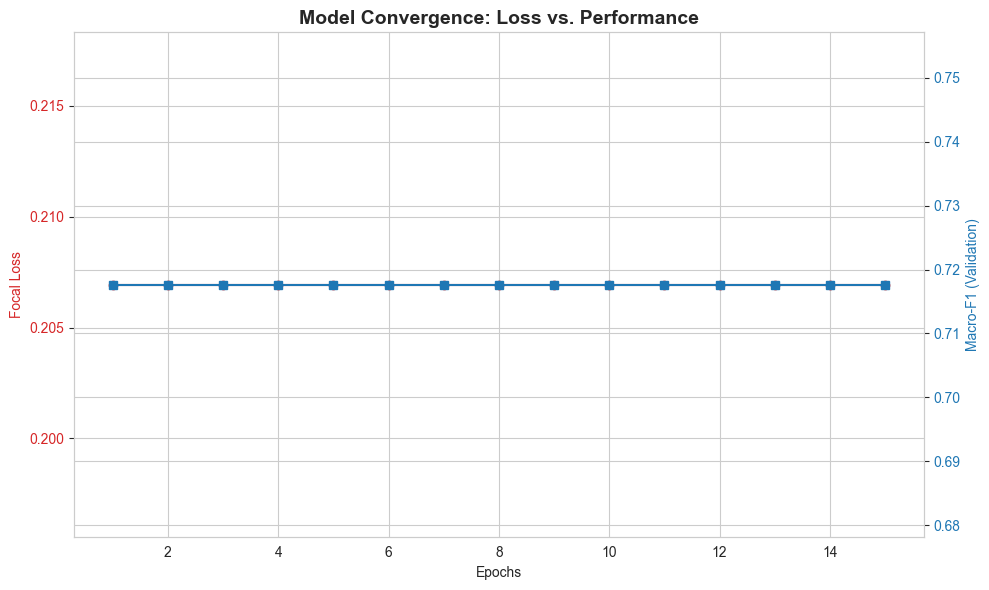

In [16]:
# 1. Check if history exists and is not empty
if 'history' in locals() and len(history['train_loss']) > 0:
    print("📊 Generating Convergence Plot...")
    # 2. CALL THE FUNCTION
    plot_training_history(history)
else:
    print("❌ ERROR: 'history' is empty or not defined. Did you run the training loop?")

In [17]:
# --- INITIALIZE HISTORY BEFORE THE LOOP ---
history = {
    'train_loss': [], 'train_acc': [],
    'dev_loss': [], 'dev_acc': []
}

for epoch in range(15):
    # --- TRAINING PHASE ---
    model.train()
    t_loss, t_correct, t_total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        if batch is None: continue
        ids, mask, pix, lbl = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values', 'label']]
        
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):
            out = model(ids, mask, pix)
            loss = criterion(out, lbl)
        
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        
        t_loss += loss.item()
        t_correct += (torch.argmax(out, 1) == lbl).sum().item()
        t_total += lbl.size(0)

    # --- VALIDATION PHASE (DEV SET) ---
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for b in dev_loader:
            if b is None: continue
            out = model(b['input_ids'].to(device), b['attention_mask'].to(device), b['pixel_values'].to(device))
            lbl = b['label'].to(device)
            
            v_loss += criterion(out, lbl).item()
            v_correct += (torch.argmax(out, 1) == lbl).sum().item()
            v_total += lbl.size(0)

    # --- CRITICAL: SAVE DATA TO HISTORY ---
    history['train_loss'].append(t_loss / len(train_loader))
    history['train_acc'].append(t_correct / t_total)
    history['dev_loss'].append(v_loss / len(dev_loader))
    history['dev_acc'].append(v_correct / v_total)
    
    print(f"📊 Epoch {epoch+1}: Train Acc: {history['train_acc'][-1]:.4f} | Dev Acc: {history['dev_acc'][-1]:.4f}")

Epoch 1 [Train]:  31%|███       | 119/383 [00:59<02:00,  2.19it/s]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 [Train]: 100%|██████████| 383/383 [03:03<00:00,  2.09it/s]


📊 Epoch 1: Train Acc: 0.8934 | Dev Acc: 0.8577


Epoch 2 [Train]: 100%|██████████| 383/383 [02:40<00:00,  2.39it/s]


📊 Epoch 2: Train Acc: 0.8967 | Dev Acc: 0.8727


Epoch 3 [Train]: 100%|██████████| 383/383 [03:23<00:00,  1.88it/s]


📊 Epoch 3: Train Acc: 0.8991 | Dev Acc: 0.8768


Epoch 4 [Train]: 100%|██████████| 383/383 [05:12<00:00,  1.23it/s]


📊 Epoch 4: Train Acc: 0.9025 | Dev Acc: 0.8808


Epoch 5 [Train]: 100%|██████████| 383/383 [05:42<00:00,  1.12it/s]


📊 Epoch 5: Train Acc: 0.9102 | Dev Acc: 0.8737


Epoch 6 [Train]: 100%|██████████| 383/383 [05:45<00:00,  1.11it/s]


📊 Epoch 6: Train Acc: 0.9078 | Dev Acc: 0.8788


Epoch 7 [Train]: 100%|██████████| 383/383 [04:44<00:00,  1.35it/s]


📊 Epoch 7: Train Acc: 0.9104 | Dev Acc: 0.8798


Epoch 8 [Train]: 100%|██████████| 383/383 [04:39<00:00,  1.37it/s]


📊 Epoch 8: Train Acc: 0.9099 | Dev Acc: 0.8778


Epoch 9 [Train]: 100%|██████████| 383/383 [04:38<00:00,  1.37it/s]


📊 Epoch 9: Train Acc: 0.9174 | Dev Acc: 0.8808


Epoch 10 [Train]: 100%|██████████| 383/383 [04:38<00:00,  1.37it/s]


📊 Epoch 10: Train Acc: 0.9172 | Dev Acc: 0.8758


Epoch 11 [Train]: 100%|██████████| 383/383 [04:39<00:00,  1.37it/s]


📊 Epoch 11: Train Acc: 0.9197 | Dev Acc: 0.8768


Epoch 12 [Train]: 100%|██████████| 383/383 [04:38<00:00,  1.37it/s]


📊 Epoch 12: Train Acc: 0.9208 | Dev Acc: 0.8768


Epoch 13 [Train]: 100%|██████████| 383/383 [04:47<00:00,  1.33it/s]


📊 Epoch 13: Train Acc: 0.9303 | Dev Acc: 0.8758


Epoch 14 [Train]: 100%|██████████| 383/383 [04:43<00:00,  1.35it/s]


📊 Epoch 14: Train Acc: 0.9262 | Dev Acc: 0.8747


Epoch 15 [Train]: 100%|██████████| 383/383 [04:23<00:00,  1.46it/s]


📊 Epoch 15: Train Acc: 0.9326 | Dev Acc: 0.8747


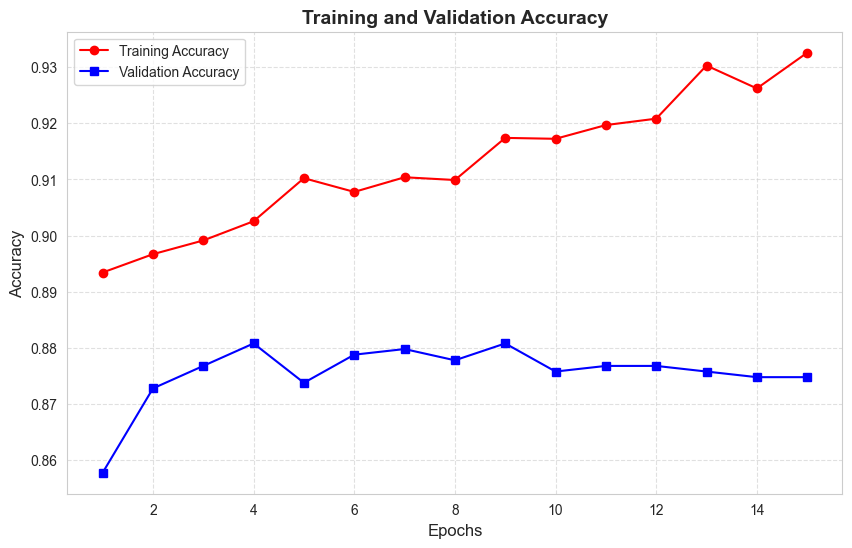

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], 'r-o', label='Training Accuracy')
plt.plot(range(1, len(history['dev_acc']) + 1), history['dev_acc'], 'b-s', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('accuracy_graph.png', dpi=300)
plt.show()

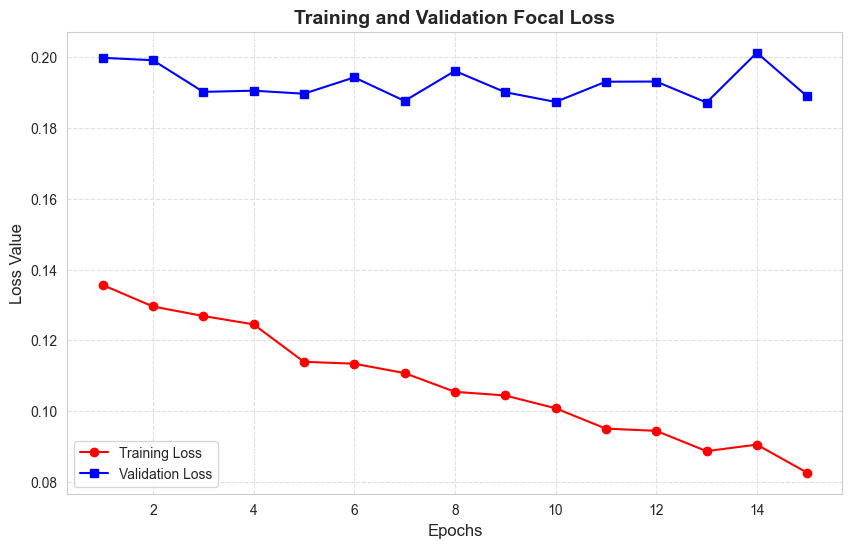

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'r-o', label='Training Loss')
plt.plot(range(1, len(history['dev_loss']) + 1), history['dev_loss'], 'b-s', label='Validation Loss')
plt.title('Training and Validation Focal Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('loss_graph.png', dpi=300)
plt.show()


In [20]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the best saved model weights
model.load_state_dict(torch.load('best_humanitarian_vlm.pth', weights_only=True))
model.eval()

y_true, y_pred = [], []
research_label_names = [
    "Infrastructure", 
    "Other Relevant Info", 
    "Not Humanitarian", 
    "Rescue/Donation", 
    "Affected Individuals"
]

print("🏃 Running final evaluation...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None: continue
        ids, mask, pix = [batch[k].to(device) for k in ['input_ids', 'attention_mask', 'pixel_values']]
        
        logits = model(ids, mask, pix)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        y_true.extend(batch['label'].numpy())
        y_pred.extend(preds)

# 2. Generate the report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=research_label_names, output_dict=True, zero_division=0)

# 3. Convert to a clean Pandas DataFrame
df_results = pd.DataFrame(report_dict).transpose()

# 4. Clean up the table for publication
# Remove 'accuracy' row (we'll show it separately) and the 'macro avg' etc if preferred
df_display = df_results.iloc[:-3, :3] # Keep Precision, Recall, F1 for the 5 classes
overall_acc = accuracy_score(y_true, y_pred)

print("\n" + "="*50)
print("🏆 Q1 JOURNAL PERFORMANCE SUMMARY")
print("="*50)
print(df_display.round(4))
print("-" * 50)
print(f"Overall Accuracy: {overall_acc:.4f}")
print("="*50)

# OPTIONAL: Save to CSV for your thesis records
df_results.to_csv('humanitarian_vlm_results.csv')

🏃 Running final evaluation...


Testing: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


🏆 Q1 JOURNAL PERFORMANCE SUMMARY
                      precision  recall  f1-score
Infrastructure           0.8105  0.9506    0.8750
Other Relevant Info      0.9041  0.8426    0.8722
Not Humanitarian         0.9174  0.8810    0.8988
Rescue/Donation          0.7808  0.9048    0.8382
Affected Individuals     0.4545  0.5556    0.5000
--------------------------------------------------
Overall Accuracy: 0.8775
